In [1]:
# -*- coding: utf-8 -*-
# === 1. Basic Imports and Setup ===
import pandas as pd
import numpy as np
import networkx as nx
import ast
from collections import Counter
import re # For text cleaning
import os # For file path operations
import gc # Garbage collection
import warnings
import pickle # To save/load objects like parameters

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc, balanced_accuracy_score

import lightgbm as lgb
# import optuna # Keep commented out unless re-tuning

# For progress bars
from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# --- Configuration ---
N_SPLITS = 5 # Number of K-Fold splits
SEED = 42
PAPER_FOLDER_PATH = r"C:\Users\User\OneDrive\Documents\latihan\gammafest\Paper Database" # *** IMPORTANT: UPDATE THIS PATH ***
USE_FULL_TEXT = True # Set to False if text files are unavailable or TF-IDF fails
USE_ABSTRACT_TFIDF = True # Set to True if abstract data is available and you want to include it
PARAMS_FILENAME = "best_lgbm_params_cv.pkl" # File to load/save best Optuna params

# --- Helper Functions ---
def safe_literal_eval(val):
    try:
        # Handle NaN/null
        if pd.isna(val):
            return []
        
        # Kalau udah list, return langsung
        if isinstance(val, list):
            return val
        
        # Kalau string, split pakai semicolon dan strip spasi
        if isinstance(val, str):
            return [item.strip() for item in val.split(';') if item.strip()]
        
        # Default fallback
        return []
    
    except Exception:
        return []


def jaccard_similarity(list1, list2):
    set1 = set(list1) if isinstance(list1, list) else set()
    set2 = set(list2) if isinstance(list2, list) else set()
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def clean_text_basic(text):
    """Basic text cleaning for titles and similar short texts. Keeps hyphens."""
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s-]', '', text) # Keep letters, numbers, spaces, hyphens
    text = re.sub(r'\s+', ' ', text).strip() # Consolidate whitespace
    return text

def clean_full_text(text):
    """Basic text cleaning for full paper text/abstracts. Keeps hyphens."""
    if pd.isna(text): return ""
    text = str(text).lower()
    # Keep letters, numbers, spaces, and hyphens. Remove others.
    text = re.sub(r'[^a-z0-9\s-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() # Consolidate whitespace
    return text

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === 2. Load data ===
print("--- Loading Data ---")
try:
    # Load original data into temporary variables
    train_orig = pd.read_csv("train.csv")
    test_orig = pd.read_csv("test.csv")
    metadata_orig = pd.read_csv("papers_metadata.csv")
    print("Original data loaded successfully.")

    # --- MODIFICATION: Create explicit working copies ---
    train_df = train_orig.copy()
    test_df = test_orig.copy()
    metadata_df = metadata_orig.copy()
    print("Working copies created.")
    # --- End Modification ---

    # Optional: Delete original variables if memory is extremely tight,
    # but keeping them is safer if memory allows.
    # del train_orig, test_orig, metadata_orig

except FileNotFoundError as e:
    print(f"Error loading data file: {e}. Make sure train.csv, test.csv, and papers_metadata.csv are in the correct directory.")
    # Handle error appropriately, e.g., exit()

gc.collect()

--- Loading Data ---
Original data loaded successfully.
Working copies created.


0

In [3]:
# === 3. Ensure Consistent Paper ID Types ===
print("\n--- Standardizing Paper ID Types ---")
train_df['paper'] = train_df['paper'].astype(str)
train_df['referenced_paper'] = train_df['referenced_paper'].astype(str)
test_df['paper'] = test_df['paper'].astype(str)
test_df['referenced_paper'] = test_df['referenced_paper'].astype(str)
metadata_df['paper_id'] = metadata_df['paper_id'].astype(str)
print("Paper ID types standardized.")


--- Standardizing Paper ID Types ---
Paper ID types standardized.


In [4]:
# === 4. Prepare Metadata ===
print("\n--- Preprocessing Metadata ---")
metadata_df['cited_by_count'] = pd.to_numeric(metadata_df['cited_by_count'], errors='coerce').fillna(0)
metadata_df['log_cited_by_count'] = np.log1p(metadata_df['cited_by_count'])

print("Applying safe_literal_eval to authors and concepts...")
metadata_df['authors_list'] = metadata_df['authors'].progress_apply(safe_literal_eval)
metadata_df['concepts_list'] = metadata_df['concepts'].progress_apply(safe_literal_eval)

metadata_df['num_authors'] = metadata_df['authors_list'].apply(len)
metadata_df['num_concepts'] = metadata_df['concepts_list'].apply(len)

metadata_df['type'].fillna('Unknown', inplace=True)
# Handle potential NaN or non-numeric years before filling
metadata_df['publication_year'] = pd.to_numeric(metadata_df['publication_year'], errors='coerce')
median_year = metadata_df['publication_year'].median()
if pd.isna(median_year):
    median_year = 2010 # Fallback if median cannot be calculated
    print(f"Warning: Could not calculate median year, using fallback: {median_year}")
metadata_df['publication_year'].fillna(median_year, inplace=True)
metadata_df['publication_year'] = metadata_df['publication_year'].astype(int) # Ensure year is integer

print("Cleaning titles...")
metadata_df['title_cleaned'] = metadata_df['title'].progress_apply(clean_text_basic)

# --- MODIFICATION: Add abstract cleaning ---
# Check if 'abstract' column exists, otherwise skip this part or load from elsewhere
if 'abstract' in metadata_df.columns:
    print("Cleaning abstracts...")
    metadata_df['abstract_cleaned'] = metadata_df['abstract'].progress_apply(clean_full_text)
    print("Abstracts cleaned.")
    USE_ABSTRACT_TFIDF = True # Enable if column exists and cleaning succeeds
else:
    print("Warning: 'abstract' column not found in metadata_df. Skipping abstract cleaning and TF-IDF.")
    metadata_df['abstract_cleaned'] = "" # Add empty column to prevent errors later if needed
    USE_ABSTRACT_TFIDF = False # Disable abstract features if column missing

print("Metadata preprocessed.")
gc.collect()


--- Preprocessing Metadata ---
Applying safe_literal_eval to authors and concepts...


100%|██████████| 4354/4354 [00:00<00:00, 621515.83it/s]


Cleaning titles...


100%|██████████| 4354/4354 [00:00<00:00, 334830.67it/s]

Metadata preprocessed.


9

In [5]:
# === 5. Full Text Data Processing ===
print("\n--- Processing Full Text Data ---")
# --- 5a. Identify All Paper IDs ---
all_paper_ids_set = set(train_df['paper']) | set(train_df['referenced_paper']) | \
                    set(test_df['paper']) | set(test_df['referenced_paper']) | \
                    set(metadata_df['paper_id'])
all_paper_ids = list(all_paper_ids_set)
print(f"Found {len(all_paper_ids)} unique paper IDs across all datasets.")

# --- 5b. Extract, Clean, and Store Full Text ---
print(f"Extracting and cleaning text from folder: {PAPER_FOLDER_PATH}")
paper_id_to_cleaned_fulltext = {}
missing_files = []
read_errors = []

if not os.path.isdir(PAPER_FOLDER_PATH):
    print(f"ERROR: Paper folder path does not exist or is not a directory: {PAPER_FOLDER_PATH}")
    USE_FULL_TEXT = False
else:
    for paper_id in tqdm(all_paper_ids, desc="Processing papers"):
        filepath = os.path.join(PAPER_FOLDER_PATH, f"{paper_id}.txt")
        try:
            with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            cleaned_content = clean_full_text(content) # Clean the text using updated function
            paper_id_to_cleaned_fulltext[paper_id] = cleaned_content
        except FileNotFoundError:
            missing_files.append(paper_id)
            paper_id_to_cleaned_fulltext[paper_id] = "" # Store empty string
        except Exception as e:
            read_errors.append(paper_id)
            paper_id_to_cleaned_fulltext[paper_id] = ""

    if missing_files:
        print(f"Warning: Could not find files for {len(missing_files)} paper IDs.")
    if read_errors:
        print(f"Warning: Errors occurred while reading files for {len(read_errors)} paper IDs.")
    print(f"Extracted and cleaned text for {len(paper_id_to_cleaned_fulltext) - len(missing_files) - len(read_errors)} papers.")

# --- 5c. TF-IDF Vectorization on Full Text ---
paper_id_to_tfidf_fulltext = {} # Initialize empty
tfidf_matrix_fulltext = None
tfidf_vectorizer_fulltext = None

if USE_FULL_TEXT and paper_id_to_cleaned_fulltext:
    print("\nCalculating TF-IDF vectors for cleaned full text...")
    # Ensure consistent ordering for TF-IDF matrix alignment
    ordered_paper_ids_text = [pid for pid in all_paper_ids if pid in paper_id_to_cleaned_fulltext]
    documents = [paper_id_to_cleaned_fulltext[pid] for pid in ordered_paper_ids_text]

    # --- MODIFICATION: Changed ngram_range ---
    tfidf_vectorizer_fulltext = TfidfVectorizer(
        max_features=25000, # Keep relatively high, adjust based on memory
        stop_words='english',
        ngram_range=(1, 2), # Experiment: Changed from (1, 1)
        min_df=5,
        max_df=0.7
    )
    try:
        tfidf_matrix_fulltext = tfidf_vectorizer_fulltext.fit_transform(tqdm(documents, desc="Fitting Full Text TF-IDF"))
        print(f"Full Text TF-IDF matrix shape: {tfidf_matrix_fulltext.shape}")
        # Create lookup dictionary using the ordered list
        paper_id_to_tfidf_fulltext = {pid: tfidf_matrix_fulltext[i] for i, pid in enumerate(ordered_paper_ids_text)}
        print("Full Text TF-IDF vector lookup dictionary created.")
    except MemoryError:
        print("\nMemoryError during full text TF-IDF. Reducing max_features to 15000.")
        USE_FULL_TEXT = False # Disable feature if it fails even after retry
        tfidf_vectorizer_fulltext = TfidfVectorizer(max_features=15000, stop_words='english', ngram_range=(1, 2), min_df=5, max_df=0.7)
        try:
            tfidf_matrix_fulltext = tfidf_vectorizer_fulltext.fit_transform(tqdm(documents, desc="Fitting Full Text TF-IDF (Retry)"))
            print(f"Full Text TF-IDF matrix shape (Retry): {tfidf_matrix_fulltext.shape}")
            paper_id_to_tfidf_fulltext = {pid: tfidf_matrix_fulltext[i] for i, pid in enumerate(ordered_paper_ids_text)}
            print("Full Text TF-IDF vector lookup dictionary created (Retry).")
            USE_FULL_TEXT = True # Re-enable if retry successful
        except Exception as e_retry:
            print(f"Retry failed: {e_retry}. Proceeding without full text TF-IDF features.")
            USE_FULL_TEXT = False
            paper_id_to_tfidf_fulltext = {}
            tfidf_matrix_fulltext = None
            tfidf_vectorizer_fulltext = None
    except Exception as e:
        print(f"\nError during full text TF-IDF: {e}")
        print("Proceeding without full text TF-IDF features.")
        USE_FULL_TEXT = False
        paper_id_to_tfidf_fulltext = {}
        tfidf_matrix_fulltext = None
        tfidf_vectorizer_fulltext = None

    del documents
    del ordered_paper_ids_text
    if tfidf_matrix_fulltext is not None: del tfidf_matrix_fulltext # Only need lookup
    gc.collect()
else:
    print("\nSkipping full text TF-IDF calculation (USE_FULL_TEXT is False or text data empty).")
    USE_FULL_TEXT = False


--- Processing Full Text Data ---
Found 4354 unique paper IDs across all datasets.
Extracting and cleaning text from folder: C:\Users\User\OneDrive\Documents\latihan\gammafest\Paper Database


Processing papers: 100%|██████████| 4354/4354 [00:10<00:00, 430.26it/s]


Extracted and cleaned text for 4354 papers.

Calculating TF-IDF vectors for cleaned full text...


Fitting Full Text TF-IDF: 100%|██████████| 4354/4354 [00:39<00:00, 109.44it/s]


Full Text TF-IDF matrix shape: (4354, 25000)
Full Text TF-IDF vector lookup dictionary created.


In [6]:
# === 6. Title TF-IDF Vectorization ===
print("\n--- Setting up TF-IDF for Titles ---")
titles_cleaned = metadata_df['title_cleaned'].fillna("").astype(str)
tfidf_vectorizer_title = TfidfVectorizer(max_features=5000,
                                   stop_words='english',
                                   ngram_range=(1, 2)) # Keep ngrams=(1, 2) for titles

print("Fitting Title TF-IDF...")
tfidf_vectorizer_title.fit(titles_cleaned)
print("Title TF-IDF fitted.")

print("Creating Title TF-IDF lookup...")
paper_id_to_tfidf_title = {}
if 'paper_id' in metadata_df.columns and 'title_cleaned' in metadata_df.columns:
    # Ensure alignment between paper IDs and the rows used for transformation
    metadata_subset_title = metadata_df[['paper_id', 'title_cleaned']].dropna(subset=['title_cleaned']).astype(str)
    ordered_paper_ids_title = metadata_subset_title['paper_id'].tolist()
    tfidf_matrix_title = tfidf_vectorizer_title.transform(tqdm(metadata_subset_title['title_cleaned'], desc="Transforming Titles"))
    paper_id_to_tfidf_title = {pid: tfidf_matrix_title[i] for i, pid in enumerate(ordered_paper_ids_title)}
    print(f"Title TF-IDF matrix shape: {tfidf_matrix_title.shape}")
    del tfidf_matrix_title
    del ordered_paper_ids_title
else:
    print("Warning: 'paper_id' or 'title_cleaned' columns not found. Title TF-IDF features will be zero.")

del titles_cleaned
del metadata_subset_title
gc.collect()


--- Setting up TF-IDF for Titles ---
Fitting Title TF-IDF...
Title TF-IDF fitted.
Creating Title TF-IDF lookup...


Transforming Titles: 100%|██████████| 4354/4354 [00:00<00:00, 108848.16it/s]

Title TF-IDF matrix shape: (4354, 5000)


0

In [7]:
# === 7. Abstract TF-IDF Vectorization (New Section) ===
print("\n--- Setting up TF-IDF for Abstracts ---")
paper_id_to_tfidf_abstract = {}
tfidf_vectorizer_abstract = None

if USE_ABSTRACT_TFIDF and 'abstract_cleaned' in metadata_df.columns and not metadata_df['abstract_cleaned'].eq("").all():
    abstracts_cleaned = metadata_df['abstract_cleaned'].fillna("").astype(str)
    tfidf_vectorizer_abstract = TfidfVectorizer(max_features=10000, # Potentially fewer features than full text
                                       stop_words='english',
                                       ngram_range=(1, 1)) # Start with unigrams for abstracts

    print("Fitting Abstract TF-IDF...")
    tfidf_vectorizer_abstract.fit(abstracts_cleaned)
    print("Abstract TF-IDF fitted.")

    print("Creating Abstract TF-IDF lookup...")
    if 'paper_id' in metadata_df.columns:
        # Ensure alignment
        metadata_subset_abstract = metadata_df[['paper_id', 'abstract_cleaned']].dropna(subset=['abstract_cleaned']).astype(str)
        ordered_paper_ids_abstract = metadata_subset_abstract['paper_id'].tolist()
        tfidf_matrix_abstract = tfidf_vectorizer_abstract.transform(tqdm(metadata_subset_abstract['abstract_cleaned'], desc="Transforming Abstracts"))
        paper_id_to_tfidf_abstract = {pid: tfidf_matrix_abstract[i] for i, pid in enumerate(ordered_paper_ids_abstract)}
        print(f"Abstract TF-IDF matrix shape: {tfidf_matrix_abstract.shape}")
        del tfidf_matrix_abstract
        del ordered_paper_ids_abstract
    else:
        print("Warning: 'paper_id' column not found. Abstract TF-IDF features cannot be reliably mapped.")
        USE_ABSTRACT_TFIDF = False # Disable if mapping fails

    del abstracts_cleaned
    del metadata_subset_abstract
    gc.collect()
elif not USE_ABSTRACT_TFIDF:
    print("Skipping Abstract TF-IDF because USE_ABSTRACT_TFIDF is False.")
else:
     print("Skipping Abstract TF-IDF because 'abstract_cleaned' column is missing or empty.")
     USE_ABSTRACT_TFIDF = False # Ensure it's off if data is missing


--- Setting up TF-IDF for Abstracts ---
Skipping Abstract TF-IDF because USE_ABSTRACT_TFIDF is False.


In [8]:
# === 8. Build Citation Graph, Calculate Degrees & PageRank ===
print("\n--- Building Citation Graph and Calculating Degrees/PageRank ---")
all_edges = pd.concat([train_df[['paper', 'referenced_paper']],
                       test_df[['paper', 'referenced_paper']]], ignore_index=True)

# Create an undirected graph for neighbor-based features & PageRank
G = nx.Graph()
# Add nodes first from metadata to ensure all papers are included, even if isolated
G.add_nodes_from(metadata_df['paper_id'].unique())
edges_to_add_undirected = list(zip(all_edges['paper'], all_edges['referenced_paper']))
G.add_edges_from(edges_to_add_undirected)
print(f"Undirected graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --- MODIFICATION: Create Directed Graph and Calculate In/Out Degrees ---
G_directed = nx.DiGraph()
G_directed.add_nodes_from(metadata_df['paper_id'].unique())
# Edges: paper -> referenced_paper (paper cites referenced_paper)
edges_to_add_directed = list(zip(all_edges['paper'], all_edges['referenced_paper']))
G_directed.add_edges_from(edges_to_add_directed)
print(f"Directed graph built with {G_directed.number_of_nodes()} nodes and {G_directed.number_of_edges()} edges.")

print("Calculating node degrees...")
node_degrees_undirected = dict(G.degree()) # Undirected degrees for Jaccard, Adamic-Adar, PA
in_degrees_directed = dict(G_directed.in_degree())  # In-degree = number of citations received
out_degrees_directed = dict(G_directed.out_degree()) # Out-degree = number of papers cited
print("Directed in/out degrees calculated.")
# --- End Modification ---

print("Calculating PageRank (on undirected graph)...")
try:
    pagerank_scores = nx.pagerank(G, alpha=0.85) # Use undirected graph for standard PageRank
    metadata_df['pagerank'] = metadata_df['paper_id'].map(pagerank_scores).fillna(0)
    print("PageRank calculated and added to metadata_df.")
except Exception as e:
    print(f"Error calculating PageRank: {e}. Setting PageRank features to 0.")
    metadata_df['pagerank'] = 0

del all_edges, edges_to_add_undirected, edges_to_add_directed # Free up memory
gc.collect()


--- Building Citation Graph and Calculating Degrees/PageRank ---
Undirected graph built with 4354 nodes and 744612 edges.
Directed graph built with 4354 nodes and 746712 edges.
Calculating node degrees...
Directed in/out degrees calculated.
Calculating PageRank (on undirected graph)...
PageRank calculated and added to metadata_df.


0

In [9]:
# === 9. Feature Engineering Functions ===
print("\n--- Defining Feature Engineering Functions ---")

# --- 9a. Graph Features ---
def get_common_neighbors_count(u, v, graph):
    if u not in graph or v not in graph: return 0
    try: return len(list(nx.common_neighbors(graph, u, v)))
    except nx.NetworkXError: return 0

def get_jaccard_coefficient(u, v, graph, degrees): # Uses undirected degrees
    if u not in graph or v not in graph: return 0
    try:
         cn = len(list(nx.common_neighbors(graph, u, v)))
         # Use undirected degrees for union calculation
         union_size = degrees.get(u, 0) + degrees.get(v, 0) - cn
         return cn / union_size if union_size > 0 else 0
    except nx.NetworkXError: return 0

def get_adamic_adar(u, v, graph, degrees): # Uses undirected degrees
     if u not in graph or v not in graph: return 0
     try:
         # Use undirected degrees for Adamic-Adar calculation
         score = sum(1 / np.log1p(degrees.get(w, 0)) for w in nx.common_neighbors(graph, u, v))
         return score
     except nx.NetworkXError: return 0

def get_preferential_attachment(u, v, degrees): # Uses undirected degrees
    # Use undirected degrees for Preferential Attachment
    return degrees.get(u, 0) * degrees.get(v, 0)

# --- 9b. Text Similarity ---
def get_tfidf_similarity(u, v, vector_lookup):
    vec_u = vector_lookup.get(u)
    vec_v = vector_lookup.get(v)
    if vec_u is not None and vec_v is not None:
        # Check if vectors are sparse (output of TfidfVectorizer)
        if hasattr(vec_u, 'shape') and len(vec_u.shape) > 1 and vec_u.shape[0] == 1: # Sparse matrix check
             return cosine_similarity(vec_u, vec_v)[0, 0]
        else: # Assuming dense if not sparse (less likely here but for safety)
             return cosine_similarity([vec_u], [vec_v])[0, 0] # Needs reshaping for dense
    else:
        return 0.0

# --- 9c. Title in Text ---
def check_ref_title_in_citing_text(row, text_lookup):
    citing_text = text_lookup.get(row['paper'], "")
    ref_title_cleaned = row.get('title_cleaned_cited', "") # Already cleaned (using updated cleaner)
    if not citing_text or not ref_title_cleaned:
        return 0
    # Check if the cleaned referenced title string is in the cleaned citing text
    return 1 if ref_title_cleaned in citing_text else 0

# --- 9d. Apply All Features (Modified) ---
def apply_features(df, graph_undir, degrees_undir, in_degrees_dir, out_degrees_dir,
                   vector_lookup_title, vector_lookup_fulltext, vector_lookup_abstract,
                   text_lookup_full, use_full_text=True, use_abstract_text=True):
    print("  Calculating undirected graph features...")
    df['cn_neighbors'] = df.progress_apply(lambda row: get_common_neighbors_count(row['paper'], row['referenced_paper'], graph_undir), axis=1)
    df['jaccard_coef'] = df.progress_apply(lambda row: get_jaccard_coefficient(row['paper'], row['referenced_paper'], graph_undir, degrees_undir), axis=1)
    df['adamic_adar'] = df.progress_apply(lambda row: get_adamic_adar(row['paper'], row['referenced_paper'], graph_undir, degrees_undir), axis=1)
    df['pref_attachment'] = df.progress_apply(lambda row: get_preferential_attachment(row['paper'], row['referenced_paper'], degrees_undir), axis=1)

    # --- MODIFICATION: Add Directed Degree Features ---
    print("  Calculating directed graph features...")
    df['in_degree_citing'] = df['paper'].map(in_degrees_dir).fillna(0)
    df['out_degree_citing'] = df['paper'].map(out_degrees_dir).fillna(0)
    df['in_degree_cited'] = df['referenced_paper'].map(in_degrees_dir).fillna(0)
    df['out_degree_cited'] = df['referenced_paper'].map(out_degrees_dir).fillna(0)
    # --- End Modification ---

    print("  Calculating text features...")
    df['tfidf_cosine_sim_title'] = df.progress_apply(lambda row: get_tfidf_similarity(row['paper'], row['referenced_paper'], vector_lookup_title), axis=1)

    if use_full_text:
        print("  Calculating full text similarity...")
        df['tfidf_cosine_sim_fulltext'] = df.progress_apply(lambda row: get_tfidf_similarity(row['paper'], row['referenced_paper'], vector_lookup_fulltext), axis=1)
        print("  Calculating title-in-text feature...")
        df['binary_ref_title_in_citing_text'] = df.progress_apply(lambda row: check_ref_title_in_citing_text(row, text_lookup_full), axis=1)
    else:
        df['tfidf_cosine_sim_fulltext'] = 0.0
        df['binary_ref_title_in_citing_text'] = 0

    # --- MODIFICATION: Add Abstract Text Similarity ---
    if use_abstract_text and vector_lookup_abstract:
        print("  Calculating abstract text similarity...")
        df['tfidf_cosine_sim_abstract'] = df.progress_apply(lambda row: get_tfidf_similarity(row['paper'], row['referenced_paper'], vector_lookup_abstract), axis=1)
    else:
        df['tfidf_cosine_sim_abstract'] = 0.0
        if 'tfidf_cosine_sim_abstract' not in df.columns: # Ensure column exists if skipped
             df['tfidf_cosine_sim_abstract'] = 0.0
    # --- End Modification ---

    print("  Calculating basic & overlap features...")
    df['year_diff'] = df['publication_year_citing'] - df['publication_year_cited']
    df['log_cited_diff'] = df['log_cited_by_count_citing'] - df['log_cited_by_count_cited']
    df['same_type'] = (df['type_citing'] == df['type_cited']).astype(int)
    df['authors_overlap'] = df.progress_apply(lambda row: jaccard_similarity(row['authors_list_citing'], row['authors_list_cited']), axis=1)
    df['concepts_overlap'] = df.progress_apply(lambda row: jaccard_similarity(row['concepts_list_citing'], row['concepts_list_cited']), axis=1)
    df['has_common_author'] = df.progress_apply(lambda row: int(len(set(row['authors_list_citing']).intersection(set(row['authors_list_cited']))) > 0), axis=1)

    return df


--- Defining Feature Engineering Functions ---


In [10]:
# === 10. Merge Metadata & Apply Feature Engineering ===
print("\n--- Merging Data and Applying All Feature Engineering ---")

def merge_and_engineer_enhanced(df_base, metadata,
                                graph_undir, degrees_undir, in_degrees_dir, out_degrees_dir,
                                vector_lookup_title, vector_lookup_fulltext, vector_lookup_abstract,
                                text_lookup_full, use_full_text=True, use_abstract_text=True):
    """Merges base df with metadata and applies all feature engineering steps."""
    metadata_citing = metadata.rename(columns=lambda c: f"{c}_citing" if c != 'paper_id' else c)
    metadata_cited = metadata.rename(columns=lambda c: f"{c}_cited" if c != 'paper_id' else c)

    print("   Merging citing paper metadata...")
    merged_df = pd.merge(df_base, metadata_citing, left_on='paper', right_on='paper_id', how='left')
    print(f"   Shape after merging citing: {merged_df.shape}")

    print("   Merging cited paper metadata...")
    merged_df = pd.merge(merged_df, metadata_cited, left_on='referenced_paper', right_on='paper_id', how='left', suffixes=('', '_drop'))
    merged_df.drop(columns=['paper_id', 'paper_id_drop'], inplace=True, errors='ignore')
    print(f"   Shape after merging cited: {merged_df.shape}")

    # Define essential columns needed *after* merge for feature calculation or direct use
    essential_cols = [
        'publication_year_citing', 'publication_year_cited', 'type_citing', 'type_cited',
        'authors_list_citing', 'authors_list_cited', 'concepts_list_citing', 'concepts_list_cited',
        'log_cited_by_count_citing', 'log_cited_by_count_cited',
        'num_authors_citing', 'num_authors_cited', 'num_concepts_citing', 'num_concepts_cited',
        'pagerank_citing', 'pagerank_cited',
        'title_cleaned_cited' # Needed for title-in-text feature
        # Add abstract_cleaned_citing if needed for a specific feature later
    ]
    # Fill NaNs for essential numeric/list columns *before* applying features or dropna
    # Ensure these columns exist after merge
    num_cols_to_fill = ['pagerank_citing', 'pagerank_cited', 'log_cited_by_count_citing', 'log_cited_by_count_cited']
    for col in num_cols_to_fill:
         if col in merged_df.columns:
             merged_df[col] = merged_df[col].fillna(0)

    list_cols_to_fill = ['authors_list_citing', 'authors_list_cited', 'concepts_list_citing', 'concepts_list_cited']
    for col in list_cols_to_fill:
        if col in merged_df.columns:
             # Apply the lambda function only if the column exists and is not already processed/empty
             if not merged_df[col].apply(lambda x: isinstance(x, list)).all():
                  merged_df[col] = merged_df[col].apply(lambda x: x if isinstance(x, list) else [])
        else:
             # If a list column is missing entirely after merge, create it with empty lists
             merged_df[col] = [[] for _ in range(len(merged_df))]


    # Drop rows only if essential columns needed downstream are missing *after* imputation where possible
    cols_to_check_for_na = [col for col in essential_cols if col in merged_df.columns]
    initial_rows = len(merged_df)
    nan_counts_before_drop = merged_df[cols_to_check_for_na].isnull().sum()
    if nan_counts_before_drop.sum() > 0:
         print(f"   NaN counts in essential columns BEFORE dropna check:\n{nan_counts_before_drop[nan_counts_before_drop > 0]}")

    merged_df.dropna(subset=cols_to_check_for_na, inplace=True) # Drop rows missing essential info needed for feature calc
    print(f"   Dropped {initial_rows - len(merged_df)} rows due to missing essential metadata for feature calculation.")
    print(f"   Shape after dropna: {merged_df.shape}")

    if len(merged_df) == 0:
        print("   ERROR: No data remaining after merging and dropping NaNs inside function.")
        return pd.DataFrame()

    # Apply core features
    merged_df = apply_features(merged_df, graph_undir, degrees_undir, in_degrees_dir, out_degrees_dir,
                               vector_lookup_title, vector_lookup_fulltext, vector_lookup_abstract,
                               text_lookup_full, use_full_text, use_abstract_text)
    print(f"   Shape after apply_features: {merged_df.shape}")

    # --- Calculate Derived & Advanced Interaction Features ---
    print("   Calculating derived PageRank and interaction features...")
    epsilon = 1e-6 # For safe division

    # Basic Derived Features (as before)
    if 'pagerank_citing' in merged_df.columns and 'pagerank_cited' in merged_df.columns:
        merged_df['pagerank_diff'] = merged_df['pagerank_citing'].fillna(0) - merged_df['pagerank_cited'].fillna(0)
    else: merged_df['pagerank_diff'] = 0

    if 'jaccard_coef' in merged_df.columns and 'tfidf_cosine_sim_title' in merged_df.columns:
        merged_df['interact_jacc_tfidf_title'] = merged_df['jaccard_coef'].fillna(0) * merged_df['tfidf_cosine_sim_title'].fillna(0)
    else: merged_df['interact_jacc_tfidf_title'] = 0

    if 'cn_neighbors' in merged_df.columns and 'num_authors_citing' in merged_df.columns and 'num_authors_cited' in merged_df.columns:
        denominator = merged_df['num_authors_citing'].fillna(0) + merged_df['num_authors_cited'].fillna(0) + epsilon
        merged_df['interact_cn_div_authors'] = merged_df['cn_neighbors'].fillna(0) / denominator
    else: merged_df['interact_cn_div_authors'] = 0

    # Advanced Interaction Features (as before)
    if USE_FULL_TEXT and 'tfidf_cosine_sim_fulltext' in merged_df.columns and 'pagerank_diff' in merged_df.columns:
        merged_df['interact_tfidf_full_pagerank_diff'] = merged_df['tfidf_cosine_sim_fulltext'].fillna(0) * merged_df['pagerank_diff'].fillna(0)
    else: merged_df['interact_tfidf_full_pagerank_diff'] = 0

    if USE_FULL_TEXT and 'tfidf_cosine_sim_fulltext' in merged_df.columns and 'jaccard_coef' in merged_df.columns:
        merged_df['interact_tfidf_full_jaccard'] = merged_df['tfidf_cosine_sim_fulltext'].fillna(0) * merged_df['jaccard_coef'].fillna(0)
    else: merged_df['interact_tfidf_full_jaccard'] = 0

    if 'log_cited_diff' in merged_df.columns and 'pagerank_diff' in merged_df.columns:
         merged_df['interact_logcite_diff_pagerank_diff'] = merged_df['log_cited_diff'].fillna(0) * merged_df['pagerank_diff'].fillna(0)
    else: merged_df['interact_logcite_diff_pagerank_diff'] = 0

    if 'pagerank_diff' in merged_df.columns and 'jaccard_coef' in merged_df.columns:
        merged_df['interact_pagerank_diff_jaccard'] = merged_df['pagerank_diff'].fillna(0) * merged_df['jaccard_coef'].fillna(0)
    else: merged_df['interact_pagerank_diff_jaccard'] = 0

    if USE_FULL_TEXT and 'tfidf_cosine_sim_fulltext' in merged_df.columns and 'year_diff' in merged_df.columns:
         merged_df['ratio_tfidf_full_year_diff'] = merged_df['tfidf_cosine_sim_fulltext'].fillna(0) / (merged_df['year_diff'].abs() + epsilon)
    else: merged_df['ratio_tfidf_full_year_diff'] = 0

    if 'log_cited_diff' in merged_df.columns and 'year_diff' in merged_df.columns:
         merged_df['ratio_logcite_diff_year_diff'] = merged_df['log_cited_diff'].fillna(0) / (merged_df['year_diff'].abs() + epsilon)
    else: merged_df['ratio_logcite_diff_year_diff'] = 0

    # --- NEW Interaction Features (Based on Importance Plot) ---
    print("   Calculating NEW interaction features...")
    if 'log_cited_by_count_citing' in merged_df.columns and 'pagerank_cited' in merged_df.columns:
         merged_df['interact_logcite_cite_pagerank_ref'] = merged_df['log_cited_by_count_citing'].fillna(0) * merged_df['pagerank_cited'].fillna(0)
    else: merged_df['interact_logcite_cite_pagerank_ref'] = 0

    if 'log_cited_by_count_cited' in merged_df.columns and 'pagerank_citing' in merged_df.columns:
         merged_df['interact_logcite_ref_pagerank_cite'] = merged_df['log_cited_by_count_cited'].fillna(0) * merged_df['pagerank_citing'].fillna(0)
    else: merged_df['interact_logcite_ref_pagerank_cite'] = 0

    if 'log_cited_by_count_citing' in merged_df.columns and 'tfidf_cosine_sim_fulltext' in merged_df.columns and USE_FULL_TEXT:
         merged_df['interact_logcite_cite_tfidf_full'] = merged_df['log_cited_by_count_citing'].fillna(0) * merged_df['tfidf_cosine_sim_fulltext'].fillna(0)
    else: merged_df['interact_logcite_cite_tfidf_full'] = 0

    if 'pagerank_citing' in merged_df.columns and 'pref_attachment' in merged_df.columns:
         merged_df['interact_pagerank_cite_pref_attach'] = merged_df['pagerank_citing'].fillna(0) * merged_df['pref_attachment'].fillna(0)
    else: merged_df['interact_pagerank_cite_pref_attach'] = 0
    # --- End NEW Features ---

    print("Feature engineering complete for this dataset.")
    return merged_df

# --- Run Feature Engineering ---
print("\nProcessing Training Data...")
train_processed = merge_and_engineer_enhanced(
    train_df, metadata_df.copy(), G, node_degrees_undirected, in_degrees_directed, out_degrees_directed,
    paper_id_to_tfidf_title, paper_id_to_tfidf_fulltext, paper_id_to_tfidf_abstract,
    paper_id_to_cleaned_fulltext,
    USE_FULL_TEXT, USE_ABSTRACT_TFIDF
)
print(f"Final shape of train_processed returned: {train_processed.shape}")
gc.collect()

print("\nProcessing Test Data...")
test_processed = merge_and_engineer_enhanced(
    test_df, metadata_df.copy(), G, node_degrees_undirected, in_degrees_directed, out_degrees_directed,
    paper_id_to_tfidf_title, paper_id_to_tfidf_fulltext, paper_id_to_tfidf_abstract,
    paper_id_to_cleaned_fulltext,
    USE_FULL_TEXT, USE_ABSTRACT_TFIDF
)
print(f"Final shape of test_processed returned: {test_processed.shape}")
gc.collect()

# --- Cleanup Graph Data ---
print("\nCleaning up graph objects...")
del G, G_directed, node_degrees_undirected, in_degrees_directed, out_degrees_directed, pagerank_scores
gc.collect()


--- Merging Data and Applying All Feature Engineering ---

Processing Training Data...
   Merging citing paper metadata...
   Shape after merging citing: (410691, 20)
   Merging cited paper metadata...
   Shape after merging cited: (410691, 35)
   Dropped 0 rows due to missing essential metadata for feature calculation.
   Shape after dropna: (410691, 35)
  Calculating undirected graph features...


100%|██████████| 410691/410691 [00:01<00:00, 210244.41it/s]


  Calculating directed graph features...
  Calculating text features...


100%|██████████| 410691/410691 [02:03<00:00, 3315.60it/s]


  Calculating full text similarity...


100%|██████████| 410691/410691 [02:35<00:00, 2644.74it/s]


  Calculating title-in-text feature...


100%|██████████| 410691/410691 [00:08<00:00, 50589.65it/s]


  Calculating basic & overlap features...


100%|██████████| 410691/410691 [00:02<00:00, 148409.46it/s]


   Shape after apply_features: (410691, 53)
   Calculating derived PageRank and interaction features...
   Calculating NEW interaction features...
Feature engineering complete for this dataset.
Final shape of train_processed returned: (410691, 66)

Processing Test Data...
   Merging citing paper metadata...
   Shape after merging citing: (336021, 20)
   Merging cited paper metadata...
   Shape after merging cited: (336021, 35)
   Dropped 0 rows due to missing essential metadata for feature calculation.
   Shape after dropna: (336021, 35)
  Calculating undirected graph features...


100%|██████████| 336021/336021 [00:02<00:00, 167835.83it/s]


  Calculating directed graph features...
  Calculating text features...


100%|██████████| 336021/336021 [01:36<00:00, 3498.16it/s]


  Calculating full text similarity...


100%|██████████| 336021/336021 [02:04<00:00, 2700.89it/s]


  Calculating title-in-text feature...


100%|██████████| 336021/336021 [00:06<00:00, 49288.78it/s]


  Calculating basic & overlap features...


100%|██████████| 336021/336021 [00:02<00:00, 139516.94it/s]


   Shape after apply_features: (336021, 53)
   Calculating derived PageRank and interaction features...
   Calculating NEW interaction features...
Feature engineering complete for this dataset.
Final shape of test_processed returned: (336021, 66)

Cleaning up graph objects...


8976

In [11]:
# === 11. Define Feature Groups and Preprocessing Pipeline ---
print("\n--- Setting up Final Preprocessing Pipeline ---")

numerical_features = [
    # Metadata based
    'log_cited_by_count_citing', 'log_cited_by_count_cited',
    'num_authors_citing', 'num_authors_cited',
    'num_concepts_citing', 'num_concepts_cited',
    'year_diff',
    'log_cited_diff',
    # --- MODIFICATION: Add explicit years ---
    'publication_year_citing', 'publication_year_cited',
    # Overlap based
    'authors_overlap', 'concepts_overlap',
    # Graph based (Undirected)
    'cn_neighbors', 'jaccard_coef', 'adamic_adar', 'pref_attachment',
    # --- MODIFICATION: Add directed degrees ---
    'in_degree_citing', 'out_degree_citing', 'in_degree_cited', 'out_degree_cited',
    # Text based
    'tfidf_cosine_sim_title',
    'tfidf_cosine_sim_fulltext', # Will be removed if not used
    'tfidf_cosine_sim_abstract', # Will be removed if not used
    # Derived/Interaction Features
    'pagerank_citing', 'pagerank_cited', 'pagerank_diff',
    'interact_jacc_tfidf_title', 'interact_cn_div_authors',
    'interact_tfidf_full_pagerank_diff',
    'interact_tfidf_full_jaccard',
    'interact_logcite_diff_pagerank_diff',
    'interact_pagerank_diff_jaccard',
    'ratio_tfidf_full_year_diff',
    'ratio_logcite_diff_year_diff',
    # --- MODIFICATION: Add NEW interactions ---
    'interact_logcite_cite_pagerank_ref',
    'interact_logcite_ref_pagerank_cite',
    'interact_logcite_cite_tfidf_full',
    'interact_pagerank_cite_pref_attach'
]
categorical_features = [
    'type_citing', 'type_cited'
]
binary_features = [
    'same_type',
    'has_common_author',
    'binary_ref_title_in_citing_text' # Friend's feature
]

# Conditionally remove features if flags are False
if not USE_FULL_TEXT:
    print("Removing features dependent on full text due to USE_FULL_TEXT=False")
    numerical_features = [f for f in numerical_features if f not in [
        'tfidf_cosine_sim_fulltext',
        'interact_tfidf_full_pagerank_diff',
        'interact_tfidf_full_jaccard',
        'ratio_tfidf_full_year_diff',
        'interact_logcite_cite_tfidf_full' # New interaction depending on full text
    ]]
    binary_features = [f for f in binary_features if f != 'binary_ref_title_in_citing_text']

if not USE_ABSTRACT_TFIDF:
     print("Removing features dependent on abstract text due to USE_ABSTRACT_TFIDF=False")
     numerical_features = [f for f in numerical_features if f != 'tfidf_cosine_sim_abstract']


# Filter features available in the processed dataframes
if 'train_processed' not in locals() or train_processed is None or train_processed.empty:
     print("ERROR: train_processed DataFrame not found or is empty before feature filtering.")
     raise NameError("train_processed is not defined or empty, cannot filter features.")

features_available_train = train_processed.columns
numerical_features = [f for f in numerical_features if f in features_available_train]
categorical_features = [f for f in categorical_features if f in features_available_train]
binary_features = [f for f in binary_features if f in features_available_train]

# Check for duplicates before selection
features_all = numerical_features + categorical_features + binary_features
if len(features_all) != len(set(features_all)):
    print("ERROR: Duplicate feature names found in combined list 'features_all'. Please check definitions.")
    counts = Counter(features_all)
    duplicates = [item for item, count in counts.items() if count > 1]
    print(f"Duplicate features: {duplicates}")
    # Decide how to handle: remove duplicates or fix definitions
    features_all = sorted(list(set(features_all))) # Simple de-duplication
    print(f"Using deduplicated feature list of length: {len(features_all)}")
    # Re-filter based on deduplicated list - important if duplicates spanned types
    numerical_features = [f for f in numerical_features if f in features_all]
    categorical_features = [f for f in categorical_features if f in features_all]
    binary_features = [f for f in binary_features if f in features_all]


print(f"Final Numerical Features Used: {len(numerical_features)}")
print(f"Final Categorical Features Used: {len(categorical_features)}")
print(f"Final Binary Features Used: {len(binary_features)}")
print(f"Total features going into preprocessor: {len(features_all)}")


# Keep track of IDs/target and necessary columns before deleting large frames
if 'is_referenced' in train_processed.columns:
    target_train = train_processed['is_referenced'].copy()
else:
     print("ERROR: 'is_referenced' column not found in train_processed. Cannot proceed.")
     raise KeyError("'is_referenced' column missing")

if 'id' in test_processed.columns:
    ids_test = test_processed['id'].copy()
else:
     print("ERROR: 'id' column not found in test_processed. Cannot proceed.")
     raise KeyError("'id' column missing")

# Extract needed year columns from test_processed BEFORE deleting it
if 'id' in test_processed.columns and \
   'publication_year_citing' in test_processed.columns and \
   'publication_year_cited' in test_processed.columns:
    test_years_info = test_processed[['id', 'publication_year_citing', 'publication_year_cited']].copy()
    test_years_info.set_index('id', inplace=True) # Set index for easier merging later
    print("Extracted year information for post-processing.")
else:
    print("ERROR: Could not extract necessary year columns from test_processed for post-processing.")
    test_years_info = None # Indicate failure


# Select features for X
# Recreate features_all after filtering to ensure only available columns are selected
features_all = numerical_features + categorical_features + binary_features
X_train = train_processed[features_all].copy()

# Ensure test set has the same columns, adding missing ones with NaN if needed
for col in features_all:
    if col not in test_processed.columns:
        print(f"Warning: Column '{col}' not found in test_processed during feature selection. Adding it with NaNs.")
        test_processed[col] = np.nan # Add missing column filled with NaN
X_test = test_processed[features_all].copy() # Select the same columns


# --- Cleanup Intermediate DataFrames ---
print("\nCleaning up intermediate dataframes and objects...")
del train_processed, test_processed
del metadata_df # No longer needed after merging
del paper_id_to_tfidf_title, tfidf_vectorizer_title
if 'tfidf_vectorizer_fulltext' in locals() and tfidf_vectorizer_fulltext is not None: del tfidf_vectorizer_fulltext
if 'paper_id_to_tfidf_fulltext' in locals(): del paper_id_to_tfidf_fulltext
if 'paper_id_to_cleaned_fulltext' in locals(): del paper_id_to_cleaned_fulltext
if 'tfidf_vectorizer_abstract' in locals() and tfidf_vectorizer_abstract is not None: del tfidf_vectorizer_abstract
if 'paper_id_to_tfidf_abstract' in locals(): del paper_id_to_tfidf_abstract
gc.collect()
# --- End Cleanup ---


# Define transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Use sparse=False for LGBM
])

# Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features) # Keep binary features as they are
    ],
    remainder='drop', # Drop any columns not specified
    verbose_feature_names_out=False # Keep original names simpler
)
# Set output to pandas DataFrame to preserve column names
preprocessor.set_output(transform="pandas")


--- Setting up Final Preprocessing Pipeline ---
Removing features dependent on abstract text due to USE_ABSTRACT_TFIDF=False
Final Numerical Features Used: 37
Final Categorical Features Used: 2
Final Binary Features Used: 3
Total features going into preprocessor: 42
Extracted year information for post-processing.

Cleaning up intermediate dataframes and objects...


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['log_cited_by_count_citing',
                                  'log_cited_by_count_cited',
                                  'num_authors_citing', 'num_authors_cited',
                                  'num_concepts_citing', 'num_concepts_cited',
                                  'year_diff', 'log_cited_diff',
                                  'publication_year_citing',
                                  'publication_year_cited',...
                                  'interact_logcite_diff_pagerank_diff', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['type_citing', 'type_cited']),
                                ('binary', 'passthrough',
                                 ['same_type', 'has_common_author',
                                  'binary_ref_title_in_citing_text'])],
                  verbose_feature_names_out=False)

In [12]:
# === 12. Apply Final Preprocessing ===
print("\n--- Applying Final Preprocessing ---")
try:
    # Fit on training data and transform both train and test
    print("Fitting and transforming training data...")
    X_train_final = preprocessor.fit_transform(X_train)
    print("Transforming test data...")
    X_test_final = preprocessor.transform(X_test) # Use transform only for test data

    feature_names_out = preprocessor.get_feature_names_out()
    print(f"Output feature names example: {feature_names_out[:10]}...")
    print(f"Total features after preprocessing: {len(feature_names_out)}")

    print(f"\nShape of final training features: {X_train_final.shape}")
    print(f"Shape of final test features: {X_test_final.shape}")
    print(f"Shape of training target: {target_train.shape}") # Verify target shape

except Exception as e:
    print(f"Error during final preprocessing: {e}")
    print("Check feature lists and data consistency.")
    # Potentially print shapes or head of X_train/X_test for debugging
    # print("X_train head:\n", X_train.head())
    # print("X_test head:\n", X_test.head())
    raise

# --- Cleanup X_train, X_test ---
del X_train, X_test
gc.collect()
# --- End Cleanup ---

print("\nPreprocessing complete.")
print("Variables available for modeling: X_train_final, target_train, X_test_final, ids_test, test_years_info")


--- Applying Final Preprocessing ---
Fitting and transforming training data...
Transforming test data...
Output feature names example: ['log_cited_by_count_citing' 'log_cited_by_count_cited'
 'num_authors_citing' 'num_authors_cited' 'num_concepts_citing'
 'num_concepts_cited' 'year_diff' 'log_cited_diff'
 'publication_year_citing' 'publication_year_cited']...
Total features after preprocessing: 61

Shape of final training features: (410691, 61)
Shape of final test features: (336021, 61)
Shape of training target: (410691,)

Preprocessing complete.
Variables available for modeling: X_train_final, target_train, X_test_final, ids_test, test_years_info


In [15]:
# === Cell 12.1: Persiapan Modeling & Parameter Default ===
print("\n--- Persiapan Modeling & Parameter Default ---")

# Pastikan target_train sudah ada dari Cell 30
if 'target_train' not in locals():
    raise NameError("Variabel target_train belum ada. Jalankan Cell 30 dulu.")

target_counts = target_train.value_counts()
print("Target Distribution:")
print(target_counts)

count_0 = target_counts.get(0, 1) # Use 1 if missing to avoid zero division
count_1 = target_counts.get(1, 1)
scale_pos_weight = count_0 / count_1
print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

# --- Definisikan Parameter Default/Nembak di sini ---
# Ini adalah parameter "nembak" awal Anda yang ingin dikalahkan/divalidasi
default_params = {
    'n_estimators': 2250, # Crucial default based on PDF analysis
    'learning_rate': 0.018,
    'num_leaves': 128,
    'max_depth': 10,
    'reg_alpha': 1.5,
    'reg_lambda': 1.2,
    'colsample_bytree': 0.75,
    'subsample': 0.8,
    'subsample_freq': 3,
    'min_child_samples': 40
}
print("Parameter default didefinisikan.")


--- Persiapan Modeling & Parameter Default ---
Target Distribution:
is_referenced
0    406399
1      4292
Name: count, dtype: int64

Calculated scale_pos_weight: 94.69
Parameter default didefinisikan.


In [16]:
# === 12.5. Fungsi Objective Optuna Baru (Menggunakan lgb.cv) =========================================================================================================================
print("\n--- Mendefinisikan Fungsi Objective Optuna dengan CV Internal ---")
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score # PR AUC
import numpy as np # Pastikan numpy diimpor

# Pastikan variabel ini sudah ada dari cell sebelumnya
# scale_pos_weight = ... (hasil perhitungan di cell 13 nanti)
# SEED = 42 # atau nilai seed mu
# X_train_final = ... (hasil preprocessing di cell 12)
# target_train = ... (target dari cell 11)

N_SPLITS_CV_OPTUNA = 3 # Jumlah fold untuk CV di dalam setiap trial Optuna (3 sudah cukup cepat)

def objective_lgb_cv(trial):
    # --- Definisikan Search Space Hyperparameter ---
    # (Ini sama seperti search space di cell 18 sebelumnya, bisa disesuaikan lagi nanti)
    params = {
        'objective': 'binary',
        'metric': 'auc', # Monitor ROC AUC, tapi kita optimalkan PR AUC
        'boosting_type': 'gbdt',
        'random_state': SEED,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,

        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000, step=250),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.04, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100)
    }

    # --- Menjalankan lgb.cv ---
    cv_folds = StratifiedKFold(n_splits=N_SPLITS_CV_OPTUNA, shuffle=True, random_state=SEED + trial.number)

    try:
        # lgb.cv butuh data dalam format lgb.Dataset
        # Jika X_train_final adalah pandas DataFrame, konversi ke numpy dulu jika perlu
        if isinstance(X_train_final, pd.DataFrame):
            X_train_np = X_train_final.values
            target_train_np = target_train.values
        else: # Asumsi sudah numpy
            X_train_np = X_train_final
            target_train_np = target_train

        train_data_lgb = lgb.Dataset(X_train_np, label=target_train_np)

        cv_results = lgb.cv(
            params,
            train_data_lgb,
            num_boost_round=params['n_estimators'], # Jumlah max estimator
            folds=cv_folds,
            metrics=['average_precision'], # Fokus optimasi ke PR AUC
            seed=SEED,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False), # ES internal lgb.cv
                lgb.log_evaluation(period=0) # Matikan log per iterasi
            ]
        )

        # Ambil skor PR AUC rata-rata terbaik
        best_pr_auc_mean = cv_results['valid average_precision-mean'][-1]
        best_iter = len(cv_results['valid average_precision-mean'])
        trial.set_user_attr("best_iteration_cv_mean", best_iter) # Simpan iterasi terbaik

        print(f"  Trial {trial.number} finished. Iter: {best_iter}, Mean PR AUC (CV): {best_pr_auc_mean:.5f}")
        return best_pr_auc_mean

    except Exception as e:
        print(f"Error during lgb.cv in trial {trial.number}: {e}")
        return 0.0 # Skor buruk jika gagal

print("Fungsi objective_lgb_cv siap digunakan.")


--- Mendefinisikan Fungsi Objective Optuna dengan CV Internal ---
Fungsi objective_lgb_cv siap digunakan.


In [17]:


# === Cell 12.6: Pencarian Hyperparameter dengan Optuna (menggunakan lgb.cv) =====================================================================================================
print("\n--- Memulai Pencarian Hyperparameter dengan Optuna (menggunakan lgb.cv) ---")
import optuna # Pastikan optuna diimpor di sini atau di cell awal
import pickle # Pastikan pickle diimpor

# Cek dependensi (pastikan variabel ini sudah ada dari cell sebelumnya)
if 'X_train_final' not in locals() or 'target_train' not in locals() or 'scale_pos_weight' not in locals():
    raise NameError("Pastikan X_train_final, target_train, dan scale_pos_weight sudah ada.")
if 'objective_lgb_cv' not in locals():
     raise NameError("Fungsi objective_lgb_cv belum didefinisikan. Jalankan Cell 12.5 dulu.")
if 'default_params' not in locals():
     raise NameError("Variabel default_params belum didefinisikan (seharusnya ada di Cell 31/13).")

study_cv = optuna.create_study(direction='maximize', study_name='lgbm_link_pred_cv_robust')
best_params_from_cv = {}
best_iter_found = default_params['n_estimators'] # Fallback awal

try:
    # Coba dengan n_trials yang lebih sedikit dulu karena lgb.cv lebih lambat
    print("Memulai optimasi Optuna...")
    study_cv.optimize(objective_lgb_cv, n_trials=30, timeout=None) # Coba 30 trial, bisa ditingkatkan nanti

    print(f"\nStudi Optuna (CV) selesai. Best trial PR AUC (CV mean): {study_cv.best_value:.5f}")
    print("Hyperparameter terbaik ditemukan:")
    best_params_from_cv = study_cv.best_params
    # Ambil iterasi terbaik dari user attribute yang disimpan di objective_lgb_cv
    best_iter_found = study_cv.best_trial.user_attrs.get("best_iteration_cv_mean", best_params_from_cv['n_estimators'])
    print(best_params_from_cv)
    print(f"Iterasi terbaik rata-rata dari CV: {best_iter_found}")

    # Simpan parameter terbaik
    PARAMS_FILENAME_CV = "best_lgbm_params_optuna_cv.pkl"
    with open(PARAMS_FILENAME_CV, 'wb') as f:
        pickle.dump(best_params_from_cv, f)
    print(f"Parameter terbaik disimpan ke {PARAMS_FILENAME_CV}")

except Exception as e_optuna:
    print(f"Error selama optimasi Optuna (CV): {e_optuna}")
    print("Menggunakan parameter default yang didefinisikan di notebook.")
    best_params_from_cv = default_params.copy()
    best_iter_found = best_params_from_cv.get('n_estimators', 2250)

# Simpan hasil terbaik di variabel global untuk digunakan cell berikutnya
GLOBAL_BEST_PARAMS_CV = best_params_from_cv
GLOBAL_BEST_ITER_CV = best_iter_found
print("\nHasil tuning disimpan di GLOBAL_BEST_PARAMS_CV dan GLOBAL_BEST_ITER_CV.")

[I 2025-04-24 14:33:04,010] A new study created in memory with name: lgbm_link_pred_cv_robust



--- Memulai Pencarian Hyperparameter dengan Optuna (menggunakan lgb.cv) ---
Memulai optimasi Optuna...
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026906 seconds.

[I 2025-04-24 14:34:04,193] Trial 0 finished with value: 0.5297498492006842 and parameters: {'n_estimators': 3750, 'learning_rate': 0.013771078555143859, 'num_leaves': 101, 'max_depth': 8, 'reg_alpha': 0.2883646900253091, 'reg_lambda': 0.21449606986108025, 'colsample_bytree': 0.880574428175315, 'subsample': 0.6530469844771571, 'subsample_freq': 2, 'min_child_samples': 98}. Best is trial 0 with value: 0.5297498492006842.


[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

[I 2025-04-24 14:35:08,925] Trial 1 finished with value: 0.5357493363354625 and parameters: {'n_estimators': 3250, 'learning_rate': 0.01676197885177835, 'num_leaves': 80, 'max_depth': 9, 'reg_alpha': 2.2477394503523027, 'reg_lambda': 1.2422806713013406, 'colsample_bytree': 0.7504732379924082, 'subsample': 0.8188551872813656, 'subsample_freq': 1, 'min_child_samples': 58}. Best is trial 1 with value: 0.5357493363354625.


  Trial 1 finished. Iter: 1338, Mean PR AUC (CV): 0.53575
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

[I 2025-04-24 14:35:38,208] Trial 2 finished with value: 0.5351122152741092 and parameters: {'n_estimators': 1750, 'learning_rate': 0.038017008299272785, 'num_leaves': 105, 'max_depth': 11, 'reg_alpha': 0.9484110138805861, 'reg_lambda': 8.655283439607642, 'colsample_bytree': 0.657810613748339, 'subsample': 0.7863008670175775, 'subsample_freq': 1, 'min_child_samples': 58}. Best is trial 1 with value: 0.5357493363354625.


  Trial 2 finished. Iter: 481, Mean PR AUC (CV): 0.53511
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037472 seconds.
You can set `force_col_wise=true` to remove th

[I 2025-04-24 14:36:20,255] Trial 3 finished with value: 0.5295784683103545 and parameters: {'n_estimators': 1000, 'learning_rate': 0.017188603929212464, 'num_leaves': 35, 'max_depth': 12, 'reg_alpha': 1.7655074912516757, 'reg_lambda': 0.6648377591715567, 'colsample_bytree': 0.8206505318774451, 'subsample': 0.6853706180144871, 'subsample_freq': 7, 'min_child_samples': 99}. Best is trial 1 with value: 0.5357493363354625.


  Trial 3 finished. Iter: 982, Mean PR AUC (CV): 0.52958
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto

[I 2025-04-24 14:38:30,759] Trial 4 finished with value: 0.5391339737717754 and parameters: {'n_estimators': 2750, 'learning_rate': 0.00958713364560203, 'num_leaves': 85, 'max_depth': 9, 'reg_alpha': 0.2443525957626646, 'reg_lambda': 2.742358122307182, 'colsample_bytree': 0.63040867882836, 'subsample': 0.8026070665064207, 'subsample_freq': 2, 'min_child_samples': 44}. Best is trial 4 with value: 0.5391339737717754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 4 finished. Iter: 2041, Mean PR AUC (CV): 0.53913
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM]

[I 2025-04-24 14:40:21,636] Trial 5 finished with value: 0.5281846066234613 and parameters: {'n_estimators': 3250, 'learning_rate': 0.005487019287128271, 'num_leaves': 118, 'max_depth': 8, 'reg_alpha': 1.0689656470517657, 'reg_lambda': 0.2777271900971487, 'colsample_bytree': 0.7699987374134442, 'subsample': 0.6278053201578211, 'subsample_freq': 6, 'min_child_samples': 90}. Best is trial 4 with value: 0.5391339737717754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 5 finished. Iter: 2230, Mean PR AUC (CV): 0.52818
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029204 seconds.
You can set `force_col_wise=tru

[I 2025-04-24 14:41:20,309] Trial 6 finished with value: 0.5266455826423627 and parameters: {'n_estimators': 3250, 'learning_rate': 0.015359827279302511, 'num_leaves': 74, 'max_depth': 7, 'reg_alpha': 0.6614602654809135, 'reg_lambda': 0.6964043152612633, 'colsample_bytree': 0.7181163998006821, 'subsample': 0.6300343963287649, 'subsample_freq': 7, 'min_child_samples': 30}. Best is trial 4 with value: 0.5391339737717754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 6 finished. Iter: 1276, Mean PR AUC (CV): 0.52665
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[I 2025-04-24 14:42:14,284] Trial 7 finished with value: 0.5191789486180863 and parameters: {'n_estimators': 1500, 'learning_rate': 0.006183143079189842, 'num_leaves': 114, 'max_depth': 6, 'reg_alpha': 2.7232511457572337, 'reg_lambda': 3.1778953188002155, 'colsample_bytree': 0.8219796245370539, 'subsample': 0.6833895377900067, 'subsample_freq': 1, 'min_child_samples': 94}. Best is trial 4 with value: 0.5391339737717754.


  Trial 7 finished. Iter: 1499, Mean PR AUC (CV): 0.51918
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Aut

[I 2025-04-24 14:43:44,996] Trial 8 finished with value: 0.5321964390960875 and parameters: {'n_estimators': 3000, 'learning_rate': 0.009937475299416642, 'num_leaves': 95, 'max_depth': 10, 'reg_alpha': 3.9897567165196874, 'reg_lambda': 0.14380463751446396, 'colsample_bytree': 0.5000895386704776, 'subsample': 0.5344829250899474, 'subsample_freq': 3, 'min_child_samples': 84}. Best is trial 4 with value: 0.5391339737717754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 8 finished. Iter: 1700, Mean PR AUC (CV): 0.53220
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info]

[I 2025-04-24 14:45:04,502] Trial 9 finished with value: 0.5292027193069528 and parameters: {'n_estimators': 3500, 'learning_rate': 0.01329002977424414, 'num_leaves': 147, 'max_depth': 6, 'reg_alpha': 4.3331043237827735, 'reg_lambda': 0.537915358920988, 'colsample_bytree': 0.5789054940736479, 'subsample': 0.7468405457945194, 'subsample_freq': 7, 'min_child_samples': 22}. Best is trial 4 with value: 0.5391339737717754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 9 finished. Iter: 1912, Mean PR AUC (CV): 0.52920
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051583 seconds.
You can set `force_col_wise=tru

[I 2025-04-24 14:45:46,604] Trial 10 finished with value: 0.530526189791262 and parameters: {'n_estimators': 2250, 'learning_rate': 0.02838198072205127, 'num_leaves': 47, 'max_depth': 5, 'reg_alpha': 0.11009784409188163, 'reg_lambda': 3.256137102533869, 'colsample_bytree': 0.6395101697154583, 'subsample': 0.8920607251846372, 'subsample_freq': 4, 'min_child_samples': 40}. Best is trial 4 with value: 0.5391339737717754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 10 finished. Iter: 1181, Mean PR AUC (CV): 0.53053
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you 

[I 2025-04-24 14:47:51,620] Trial 11 finished with value: 0.5428209403561368 and parameters: {'n_estimators': 2500, 'learning_rate': 0.008430761506420468, 'num_leaves': 66, 'max_depth': 10, 'reg_alpha': 9.176532324383832, 'reg_lambda': 2.0515986295664175, 'colsample_bytree': 0.7232120310425145, 'subsample': 0.8472372818303695, 'subsample_freq': 3, 'min_child_samples': 56}. Best is trial 11 with value: 0.5428209403561368.


  Trial 11 finished. Iter: 2500, Mean PR AUC (CV): 0.54282
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Au

[I 2025-04-24 14:49:57,178] Trial 12 finished with value: 0.5387350178581453 and parameters: {'n_estimators': 2500, 'learning_rate': 0.008380115984274414, 'num_leaves': 56, 'max_depth': 10, 'reg_alpha': 9.77968338254528, 'reg_lambda': 2.1331397364693947, 'colsample_bytree': 0.6170801485383844, 'subsample': 0.8962515125861616, 'subsample_freq': 3, 'min_child_samples': 43}. Best is trial 11 with value: 0.5428209403561368.


  Trial 12 finished. Iter: 2500, Mean PR AUC (CV): 0.53874
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Au

[I 2025-04-24 15:08:39,111] Trial 13 finished with value: 0.5251214061426598 and parameters: {'n_estimators': 2750, 'learning_rate': 0.008451751081716535, 'num_leaves': 22, 'max_depth': 10, 'reg_alpha': 0.2899988020931154, 'reg_lambda': 9.655213531046194, 'colsample_bytree': 0.5534478792900823, 'subsample': 0.8277781482373624, 'subsample_freq': 5, 'min_child_samples': 73}. Best is trial 11 with value: 0.5428209403561368.


  Trial 13 finished. Iter: 2156, Mean PR AUC (CV): 0.52512
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053693 seconds.
You can set `force_col_wise=true` to remove 

[I 2025-04-24 15:58:59,099] Trial 14 finished with value: 0.5388669302253776 and parameters: {'n_estimators': 2000, 'learning_rate': 0.010389540514810995, 'num_leaves': 69, 'max_depth': 12, 'reg_alpha': 0.13070942144367895, 'reg_lambda': 1.765623440380106, 'colsample_bytree': 0.6678661688042842, 'subsample': 0.743954851901912, 'subsample_freq': 3, 'min_child_samples': 47}. Best is trial 11 with value: 0.5428209403561368.


  Trial 14 finished. Iter: 2000, Mean PR AUC (CV): 0.53887
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Au

[I 2025-04-24 16:00:57,115] Trial 15 finished with value: 0.540115171531664 and parameters: {'n_estimators': 2500, 'learning_rate': 0.007012218597087462, 'num_leaves': 59, 'max_depth': 9, 'reg_alpha': 0.33038422368249487, 'reg_lambda': 4.6681056885515435, 'colsample_bytree': 0.7113348481007082, 'subsample': 0.8504402887876269, 'subsample_freq': 2, 'min_child_samples': 73}. Best is trial 11 with value: 0.5428209403561368.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  Trial 15 finished. Iter: 2499, Mean PR AUC (CV): 0.54012
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM

[I 2025-04-24 16:02:38,969] Trial 16 finished with value: 0.535976836035491 and parameters: {'n_estimators': 2250, 'learning_rate': 0.006414997116004556, 'num_leaves': 57, 'max_depth': 9, 'reg_alpha': 9.825900245191688, 'reg_lambda': 5.616721492369434, 'colsample_bytree': 0.7156297236865724, 'subsample': 0.8608710386135716, 'subsample_freq': 4, 'min_child_samples': 72}. Best is trial 11 with value: 0.5428209403561368.


  Trial 16 finished. Iter: 2250, Mean PR AUC (CV): 0.53598
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

[I 2025-04-24 16:03:23,005] Trial 17 finished with value: 0.5151607175225216 and parameters: {'n_estimators': 1000, 'learning_rate': 0.007099840797295422, 'num_leaves': 43, 'max_depth': 10, 'reg_alpha': 0.5192110499028628, 'reg_lambda': 4.946813476536759, 'colsample_bytree': 0.7810774675653398, 'subsample': 0.7437463233785115, 'subsample_freq': 2, 'min_child_samples': 68}. Best is trial 11 with value: 0.5428209403561368.


  Trial 17 finished. Iter: 998, Mean PR AUC (CV): 0.51516
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

[I 2025-04-24 16:04:14,897] Trial 18 finished with value: 0.5411020148788304 and parameters: {'n_estimators': 4000, 'learning_rate': 0.02186735768289923, 'num_leaves': 61, 'max_depth': 11, 'reg_alpha': 0.4794856934597436, 'reg_lambda': 1.2601397151661318, 'colsample_bytree': 0.6953281793924911, 'subsample': 0.8515794444296968, 'subsample_freq': 5, 'min_child_samples': 78}. Best is trial 11 with value: 0.5428209403561368.


  Trial 18 finished. Iter: 1056, Mean PR AUC (CV): 0.54110
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

[I 2025-04-24 16:04:41,230] Trial 19 finished with value: 0.5172779531910793 and parameters: {'n_estimators': 4000, 'learning_rate': 0.021442761731353798, 'num_leaves': 27, 'max_depth': 11, 'reg_alpha': 1.2957522886385167, 'reg_lambda': 1.1902312383621854, 'colsample_bytree': 0.8927217231193266, 'subsample': 0.5438050779282196, 'subsample_freq': 5, 'min_child_samples': 84}. Best is trial 11 with value: 0.5428209403561368.


  Trial 19 finished. Iter: 654, Mean PR AUC (CV): 0.51728
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

[I 2025-04-24 16:05:33,476] Trial 20 finished with value: 0.5385327286272751 and parameters: {'n_estimators': 1500, 'learning_rate': 0.024952755694297165, 'num_leaves': 67, 'max_depth': 11, 'reg_alpha': 5.999808577757545, 'reg_lambda': 0.38272296653933957, 'colsample_bytree': 0.8152565042872125, 'subsample': 0.8693593574949412, 'subsample_freq': 5, 'min_child_samples': 63}. Best is trial 11 with value: 0.5428209403561368.


  Trial 20 finished. Iter: 993, Mean PR AUC (CV): 0.53853
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was

[I 2025-04-24 16:06:45,619] Trial 21 finished with value: 0.5392889831253261 and parameters: {'n_estimators': 2500, 'learning_rate': 0.012164152197659399, 'num_leaves': 56, 'max_depth': 11, 'reg_alpha': 0.4979283415303502, 'reg_lambda': 1.707026141987498, 'colsample_bytree': 0.6879004680036674, 'subsample': 0.8467142538594915, 'subsample_freq': 3, 'min_child_samples': 84}. Best is trial 11 with value: 0.5428209403561368.


  Trial 21 finished. Iter: 1446, Mean PR AUC (CV): 0.53929
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Au

[I 2025-04-24 16:09:04,111] Trial 22 finished with value: 0.5368592151066615 and parameters: {'n_estimators': 2750, 'learning_rate': 0.0077539539829572296, 'num_leaves': 87, 'max_depth': 8, 'reg_alpha': 0.20137263886665768, 'reg_lambda': 4.967262479755975, 'colsample_bytree': 0.7305360524620544, 'subsample': 0.7818527029201308, 'subsample_freq': 4, 'min_child_samples': 77}. Best is trial 11 with value: 0.5428209403561368.


  Trial 22 finished. Iter: 2750, Mean PR AUC (CV): 0.53686
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011823 seconds.
You can set `force_row_wise=true` to remove 

[I 2025-04-24 16:12:16,257] Trial 23 finished with value: 0.5376191296607558 and parameters: {'n_estimators': 4000, 'learning_rate': 0.005416865808742743, 'num_leaves': 65, 'max_depth': 12, 'reg_alpha': 0.4094724081258196, 'reg_lambda': 1.0360221521781687, 'colsample_bytree': 0.6918004511982202, 'subsample': 0.8405155646820642, 'subsample_freq': 6, 'min_child_samples': 51}. Best is trial 11 with value: 0.5428209403561368.


  Trial 23 finished. Iter: 3272, Mean PR AUC (CV): 0.53762
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008029 seconds.
You can set `force_row_wise=true` to remove 

[I 2025-04-24 16:13:38,943] Trial 24 finished with value: 0.5387017437754777 and parameters: {'n_estimators': 2250, 'learning_rate': 0.02005797408930643, 'num_leaves': 42, 'max_depth': 9, 'reg_alpha': 0.7458473816433157, 'reg_lambda': 4.37565769527003, 'colsample_bytree': 0.751997989179976, 'subsample': 0.8677440134221645, 'subsample_freq': 2, 'min_child_samples': 65}. Best is trial 11 with value: 0.5428209403561368.


  Trial 24 finished. Iter: 1676, Mean PR AUC (CV): 0.53870
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Au

[I 2025-04-24 16:14:32,844] Trial 25 finished with value: 0.5333633032252784 and parameters: {'n_estimators': 3000, 'learning_rate': 0.0315036402256995, 'num_leaves': 53, 'max_depth': 10, 'reg_alpha': 0.17543839544871656, 'reg_lambda': 1.9648821791613602, 'colsample_bytree': 0.606912877391587, 'subsample': 0.7701744822032159, 'subsample_freq': 4, 'min_child_samples': 54}. Best is trial 11 with value: 0.5428209403561368.


  Trial 25 finished. Iter: 840, Mean PR AUC (CV): 0.53336
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

[I 2025-04-24 16:16:27,411] Trial 26 finished with value: 0.5353455923529417 and parameters: {'n_estimators': 2000, 'learning_rate': 0.011051193136474985, 'num_leaves': 76, 'max_depth': 11, 'reg_alpha': 0.33017923061165133, 'reg_lambda': 7.4465642753367245, 'colsample_bytree': 0.668786675428644, 'subsample': 0.7155812613549182, 'subsample_freq': 6, 'min_child_samples': 77}. Best is trial 11 with value: 0.5428209403561368.


  Trial 26 finished. Iter: 1890, Mean PR AUC (CV): 0.53535
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

[I 2025-04-24 16:18:19,501] Trial 27 finished with value: 0.5265381274732127 and parameters: {'n_estimators': 2500, 'learning_rate': 0.005062809510595882, 'num_leaves': 33, 'max_depth': 7, 'reg_alpha': 1.566496938000401, 'reg_lambda': 2.704510778689483, 'colsample_bytree': 0.7873616799343836, 'subsample': 0.8123480741246503, 'subsample_freq': 3, 'min_child_samples': 36}. Best is trial 11 with value: 0.5428209403561368.


  Trial 27 finished. Iter: 2483, Mean PR AUC (CV): 0.52654
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038240 seconds.
You can set `force_col_wise=true` to remove 

[I 2025-04-24 16:19:02,972] Trial 28 finished with value: 0.5263662663157498 and parameters: {'n_estimators': 3500, 'learning_rate': 0.019741517519916027, 'num_leaves': 62, 'max_depth': 10, 'reg_alpha': 0.7556935561138629, 'reg_lambda': 0.7226962010096369, 'colsample_bytree': 0.7042301819492629, 'subsample': 0.571897754313434, 'subsample_freq': 5, 'min_child_samples': 69}. Best is trial 11 with value: 0.5428209403561368.


  Trial 28 finished. Iter: 780, Mean PR AUC (CV): 0.52637
[LightGBM] [Info] Number of positive: 2862, number of negative: 270932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 273794, number of used features: 61
[LightGBM] [Info] Number of positive: 2861, number of negative: 270933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

[I 2025-04-24 16:20:33,556] Trial 29 finished with value: 0.5380158561626847 and parameters: {'n_estimators': 3750, 'learning_rate': 0.013600699645224068, 'num_leaves': 96, 'max_depth': 9, 'reg_alpha': 0.34216844515888356, 'reg_lambda': 1.3017964290253303, 'colsample_bytree': 0.8508462469244581, 'subsample': 0.8973176421479526, 'subsample_freq': 2, 'min_child_samples': 80}. Best is trial 11 with value: 0.5428209403561368.


  Trial 29 finished. Iter: 1394, Mean PR AUC (CV): 0.53802

Studi Optuna (CV) selesai. Best trial PR AUC (CV mean): 0.54282
Hyperparameter terbaik ditemukan:
{'n_estimators': 2500, 'learning_rate': 0.008430761506420468, 'num_leaves': 66, 'max_depth': 10, 'reg_alpha': 9.176532324383832, 'reg_lambda': 2.0515986295664175, 'colsample_bytree': 0.7232120310425145, 'subsample': 0.8472372818303695, 'subsample_freq': 3, 'min_child_samples': 56}
Iterasi terbaik rata-rata dari CV: 2500
Parameter terbaik disimpan ke best_lgbm_params_optuna_cv.pkl

Hasil tuning disimpan di GLOBAL_BEST_PARAMS_CV dan GLOBAL_BEST_ITER_CV.


In [18]:
# === Modifikasi Cell 13 (id: 341aff33) ===
print("\n--- Menyiapkan Parameter Final untuk K-Fold ---")

# Pastikan variabel default_params dan hasil Optuna (jika ada) sudah ada
if 'default_params' not in locals():
     raise NameError("default_params tidak ditemukan. Jalankan Cell 12.1 dulu.")
if 'scale_pos_weight' not in locals():
     raise NameError("scale_pos_weight tidak ditemukan. Jalankan Cell 12.1 dulu.")


# --- Gunakan Parameter Terbaik dari Optuna (CV) atau Default ---
best_params_loaded = default_params.copy() # Mulai dengan default sebagai fallback

if 'GLOBAL_BEST_PARAMS_CV' in locals() and GLOBAL_BEST_PARAMS_CV: # Cek apakah tuning berhasil
    print("Menggunakan parameter dari studi Optuna(CV) yang baru selesai.")
    best_params_loaded.update(GLOBAL_BEST_PARAMS_CV)
    # Pastikan n_estimators di-update ke hasil iterasi terbaik CV
    if 'GLOBAL_BEST_ITER_CV' in locals():
         best_params_loaded['n_estimators'] = GLOBAL_BEST_ITER_CV
         print(f"Menggunakan n_estimators = {GLOBAL_BEST_ITER_CV} dari hasil CV.")
    else:
         print(f"WARNING: GLOBAL_BEST_ITER_CV tidak ditemukan, n_estimators mungkin tidak optimal.")
         best_params_loaded['n_estimators'] = best_params_loaded.get('n_estimators', default_params['n_estimators']) # Fallback n_estimator
    # Hapus key Optuna yang tidak relevan
    best_params_loaded.pop('early_stopping_round', None)
    best_params_loaded.pop('early_stopping_rounds', None)
else:
    print("Menggunakan parameter default notebook (Optuna CV tidak dijalankan/gagal?).")
    # best_params_loaded sudah diisi default_params di awal

# --- Final Parameters untuk K-Fold Training (NO Early Stopping di K-Fold Final) ---
final_params_cv = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight, # Ambil dari Cell 12.1
    **best_params_loaded # Unpack parameter (termasuk n_estimators yg sudah disesuaikan)
}

print(f"\nParameter LGBM final yang digunakan untuk K-Fold (Cell 14/id:aa4572ef): {final_params_cv}")
if 'n_estimators' in final_params_cv:
    print(f"  -> Akan dilatih untuk {final_params_cv['n_estimators']} estimators.")
else:
    print("  -> PERINGATAN: n_estimators tidak ada dalam parameter final!")


--- Menyiapkan Parameter Final untuk K-Fold ---
Menggunakan parameter dari studi Optuna(CV) yang baru selesai.
Menggunakan n_estimators = 2500 dari hasil CV.

Parameter LGBM final yang digunakan untuk K-Fold (Cell 14/id:aa4572ef): {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': np.float64(94.68755824790307), 'n_estimators': 2500, 'learning_rate': 0.008430761506420468, 'num_leaves': 66, 'max_depth': 10, 'reg_alpha': 9.176532324383832, 'reg_lambda': 2.0515986295664175, 'colsample_bytree': 0.7232120310425145, 'subsample': 0.8472372818303695, 'subsample_freq': 3, 'min_child_samples': 56}
  -> Akan dilatih untuk 2500 estimators.


In [19]:
# === 14. Train Final Model with K-Fold (No Early Stopping) ===
print(f"\n--- Training Final K-Fold Model ({N_SPLITS} splits) ---")
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof_preds_final = np.zeros(X_train_final.shape[0])
test_preds_final = np.zeros(X_test_final.shape[0])
models = []
oof_roc_aucs = []
oof_pr_aucs = []
feature_importances = pd.DataFrame(index=feature_names_out) # Use names from preprocessor

# Wrap the KFold split with tqdm for fold progress
for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train_final, target_train), total=N_SPLITS, desc="K-Fold Training")):
    print(f"--- Training Fold {fold+1}/{N_SPLITS} ---")
    # Use .iloc for pandas compatibility as preprocessor output is pandas
    X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = target_train.iloc[train_idx], target_train.iloc[val_idx]

    model = lgb.LGBMClassifier(**final_params_cv)

    # --- MODIFICATION: Fit WITHOUT early stopping for the final run ---
    # Train for the full number of estimators defined in final_params_cv
    model.fit(X_tr, y_tr,
              eval_set=[(X_val, y_val)], # Still useful for logging if verbose=True
              eval_metric='auc', # Metric for evaluation log, can change
              callbacks=[lgb.log_evaluation(period=500)] # Log progress, NO early stopping
             )
    # --- End Modification ---

    val_pred_proba = model.predict_proba(X_val)[:, 1]
    oof_preds_final[val_idx] = val_pred_proba
    test_preds_final += model.predict_proba(X_test_final)[:, 1] / N_SPLITS
    models.append(model)

    # Store feature importances
    feature_importances[f'fold_{fold+1}'] = model.feature_importances_

    # Calculate OOF metrics for this fold
    fold_roc_auc = roc_auc_score(y_val, val_pred_proba)
    precision_fold, recall_fold, _ = precision_recall_curve(y_val, val_pred_proba)
    fold_pr_auc = auc(recall_fold, precision_fold)

    oof_roc_aucs.append(fold_roc_auc)
    oof_pr_aucs.append(fold_pr_auc)
    print(f"Fold {fold+1} OOF ROC AUC: {fold_roc_auc:.4f}, OOF PR AUC: {fold_pr_auc:.4f}")

gc.collect()


--- Training Final K-Fold Model (5 splits) ---


K-Fold Training:   0%|          | 0/5 [00:00<?, ?it/s]

--- Training Fold 1/5 ---
[LightGBM] [Info] Number of positive: 3433, number of negative: 325119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6863
[LightGBM] [Info] Number of data points in the train set: 328552, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010449 -> initscore=-4.550757
[LightGBM] [Info] Start training from score -4.550757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.973355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

K-Fold Training:  20%|██        | 1/5 [01:00<04:03, 60.79s/it]

Fold 1 OOF ROC AUC: 0.9756, OOF PR AUC: 0.5561
--- Training Fold 2/5 ---
[LightGBM] [Info] Number of positive: 3434, number of negative: 325119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6868
[LightGBM] [Info] Number of data points in the train set: 328553, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010452 -> initscore=-4.550466
[LightGBM] [Info] Start training from score -4.550466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

K-Fold Training:  40%|████      | 2/5 [01:55<02:50, 56.95s/it]

Fold 2 OOF ROC AUC: 0.9771, OOF PR AUC: 0.5581
--- Training Fold 3/5 ---
[LightGBM] [Info] Number of positive: 3434, number of negative: 325119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6863
[LightGBM] [Info] Number of data points in the train set: 328553, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010452 -> initscore=-4.550466
[LightGBM] [Info] Start training from score -4.550466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.973857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

K-Fold Training:  60%|██████    | 3/5 [02:49<01:51, 55.89s/it]

Fold 3 OOF ROC AUC: 0.9761, OOF PR AUC: 0.5504
--- Training Fold 4/5 ---
[LightGBM] [Info] Number of positive: 3434, number of negative: 325119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 328553, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010452 -> initscore=-4.550466
[LightGBM] [Info] Start training from score -4.550466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.968646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

K-Fold Training:  80%|████████  | 4/5 [03:54<00:59, 59.29s/it]

Fold 4 OOF ROC AUC: 0.9696, OOF PR AUC: 0.5285
--- Training Fold 5/5 ---
[LightGBM] [Info] Number of positive: 3433, number of negative: 325120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6866
[LightGBM] [Info] Number of data points in the train set: 328553, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010449 -> initscore=-4.550760
[LightGBM] [Info] Start training from score -4.550760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's auc: 0.97741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

K-Fold Training: 100%|██████████| 5/5 [04:49<00:00, 57.83s/it]

Fold 5 OOF ROC AUC: 0.9788, OOF PR AUC: 0.5276


921


--- Evaluating Final Model and Tuning Threshold on Combined OOF ---
Overall OOF ROC AUC: 0.9754
Overall OOF PR AUC: 0.5442

Best Threshold based on OOF F1-score: 0.9240 (OOF F1: 0.5424)
Overall OOF Balanced Accuracy (tuned): 0.7763

Overall OOF Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    406399
           1       0.53      0.56      0.54      4292

    accuracy                           0.99    410691
   macro avg       0.76      0.78      0.77    410691
weighted avg       0.99      0.99      0.99    410691



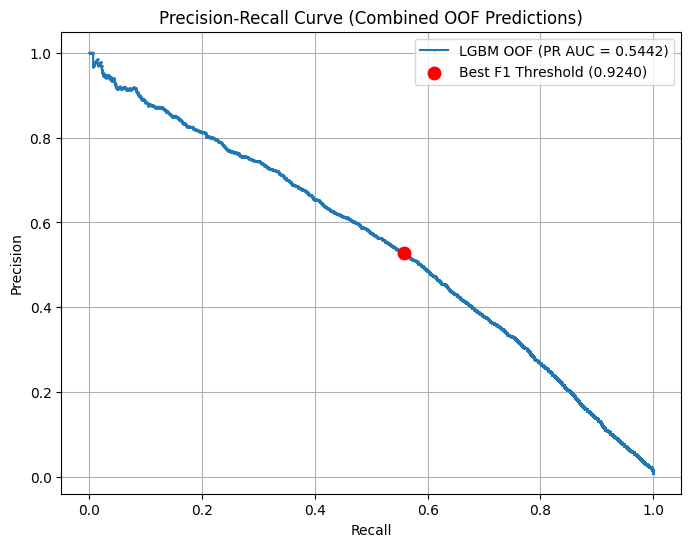

In [20]:
# === 15. Evaluate Final Model and Tune Threshold on Combined OOF ===
print("\n--- Evaluating Final Model and Tuning Threshold on Combined OOF ---")

# Ensure target_train and oof_preds_final are aligned and have correct shapes
if len(target_train) != len(oof_preds_final):
     print(f"ERROR: Length mismatch between target_train ({len(target_train)}) and oof_preds_final ({len(oof_preds_final)})")
else:
     overall_oof_roc_auc = roc_auc_score(target_train, oof_preds_final)
     precision_oof_full, recall_oof_full, thresholds_oof_full = precision_recall_curve(target_train, oof_preds_final)
     overall_oof_pr_auc = auc(recall_oof_full, precision_oof_full)

     print(f"Overall OOF ROC AUC: {overall_oof_roc_auc:.4f}")
     print(f"Overall OOF PR AUC: {overall_oof_pr_auc:.4f}")

     # Find best threshold based on F1 score
     f1_scores_oof = 2 * (precision_oof_full * recall_oof_full) / (precision_oof_full + recall_oof_full + 1e-9)
     # Exclude the last point which corresponds to recall=0, threshold=undefined
     best_f1_idx_oof = np.argmax(f1_scores_oof[:-1])
     best_threshold_oof = thresholds_oof_full[best_f1_idx_oof]
     best_f1_oof = f1_scores_oof[best_f1_idx_oof]

     print(f"\nBest Threshold based on OOF F1-score: {best_threshold_oof:.4f} (OOF F1: {best_f1_oof:.4f})")

     # Evaluate with the tuned threshold
     y_oof_pred_final_tuned = (oof_preds_final >= best_threshold_oof).astype(int)
     overall_oof_bal_acc_tuned = balanced_accuracy_score(target_train, y_oof_pred_final_tuned)
     print(f"Overall OOF Balanced Accuracy (tuned): {overall_oof_bal_acc_tuned:.4f}")
     print("\nOverall OOF Classification Report (tuned threshold):")
     print(classification_report(target_train, y_oof_pred_final_tuned, zero_division=0))

     # Plot PR Curve OOF
     plt.figure(figsize=(8, 6))
     plt.plot(recall_oof_full, precision_oof_full, marker='.', markersize=1, label=f'LGBM OOF (PR AUC = {overall_oof_pr_auc:.4f})')
     plt.scatter(recall_oof_full[best_f1_idx_oof], precision_oof_full[best_f1_idx_oof], marker='o', s=80, color='red', label=f'Best F1 Threshold ({best_threshold_oof:.4f})', zorder=5)
     plt.xlabel('Recall')
     plt.ylabel('Precision')
     plt.title('Precision-Recall Curve (Combined OOF Predictions)')
     plt.legend()
     plt.grid(True)
     plt.show()

In [21]:
# === 16. Predict on Test Set & Post-Processing ===
print(f"\n--- Predicting on Test Set (Threshold = {best_threshold_oof:.4f}) ---")
# test_preds_final already contains the averaged probabilities from the K-Fold loop
test_predictions_tuned = (test_preds_final >= best_threshold_oof).astype(int)

print(f"Predictions generated for {len(test_predictions_tuned)} test samples.")
print(f"Predicted positive count before post-processing: {np.sum(test_predictions_tuned)}")

# --- Post-Processing ---
print("\nApplying Post-Processing (Year Check)...")

# Create a DataFrame for merging
predictions_df = pd.DataFrame({
    'id': ids_test, # Use the preserved ids_test
    'predicted': test_predictions_tuned
})

# Check if test_years_info was successfully created
if test_years_info is not None:
    # Merge predictions with the preserved year info using the 'id'
    # Ensure ids_test and test_years_info index are aligned or merge explicitly
    # Reset index if 'id' is the index in test_years_info
    if test_years_info.index.name == 'id':
         test_years_info_df = test_years_info.reset_index()
    else:
         test_years_info_df = test_years_info # Assume 'id' is already a column or not needed for merge key

    # Perform the merge
    merged_test_data = pd.merge(predictions_df, test_years_info_df, on='id', how='left')

    # Check if merge resulted in expected columns and handle potential missing years if merge failed partially
    if 'publication_year_citing' not in merged_test_data.columns or 'publication_year_cited' not in merged_test_data.columns:
        print("ERROR: Year columns missing after merging predictions with year info. Cannot apply post-processing.")
        final_test_predictions = test_predictions_tuned # Fallback
    elif merged_test_data[['publication_year_citing', 'publication_year_cited']].isnull().any().any():
         print("Warning: Missing year values after merge. Imputing with fallback median_year.")
         # Impute potential NaNs that might arise from merge mismatches (though unlikely if ids_test is correct)
         merged_test_data['publication_year_citing'].fillna(median_year, inplace=True)
         merged_test_data['publication_year_cited'].fillna(median_year, inplace=True)
         print("Merged predictions with year info successfully (with imputation).")
         # Apply the rule: predict 0 if cited year is after citing year
         invalid_year_mask = merged_test_data['publication_year_cited'] > merged_test_data['publication_year_citing']
         print(f"Found {invalid_year_mask.sum()} predictions to correct based on publication year.")
         merged_test_data.loc[invalid_year_mask, 'predicted'] = 0
         final_test_predictions = merged_test_data['predicted'].values
         print(f"Predicted positive count AFTER post-processing: {np.sum(final_test_predictions)}")
    else:
         print("Merged predictions with year info successfully.")
         # Apply the rule: predict 0 if cited year is after citing year
         invalid_year_mask = merged_test_data['publication_year_cited'] > merged_test_data['publication_year_citing']
         print(f"Found {invalid_year_mask.sum()} predictions to correct based on publication year.")
         merged_test_data.loc[invalid_year_mask, 'predicted'] = 0
         final_test_predictions = merged_test_data['predicted'].values
         print(f"Predicted positive count AFTER post-processing: {np.sum(final_test_predictions)}")

else:
    print("Warning: test_years_info not available. Skipping publication year post-processing.")
    final_test_predictions = test_predictions_tuned # Use predictions without year check


--- Predicting on Test Set (Threshold = 0.9240) ---
Predictions generated for 336021 test samples.
Predicted positive count before post-processing: 3629

Applying Post-Processing (Year Check)...
Merged predictions with year info successfully.
Found 108268 predictions to correct based on publication year.
Predicted positive count AFTER post-processing: 3620


In [22]:
# === 17. Create Submission File ===
print("\n--- Creating Final Submission File ---")
submission_df = pd.DataFrame({
    'id': ids_test,
    'is_referenced': final_test_predictions
})
submission_df['is_referenced'] = submission_df['is_referenced'].astype(int) # Ensure integer type

# --- Choose a descriptive filename ---
final_submission_filename = 'submission_kfold_improved_features_yearcheck.csv'
submission_df.to_csv(final_submission_filename, index=False)

print(f"Submission file '{final_submission_filename}' created successfully.")
print("\nFinal Submission Head:")
print(submission_df.head())
print("\nFinal Submission Value Counts:")
print(submission_df['is_referenced'].value_counts())


--- Creating Final Submission File ---
Submission file 'submission_kfold_improved_features_yearcheck.csv' created successfully.

Final Submission Head:
   id  is_referenced
0   0              0
1   1              0
2   2              0
3   3              0
4   4              0

Final Submission Value Counts:
is_referenced
0    332401
1      3620
Name: count, dtype: int64



--- Calculating and Displaying Feature Importance ---


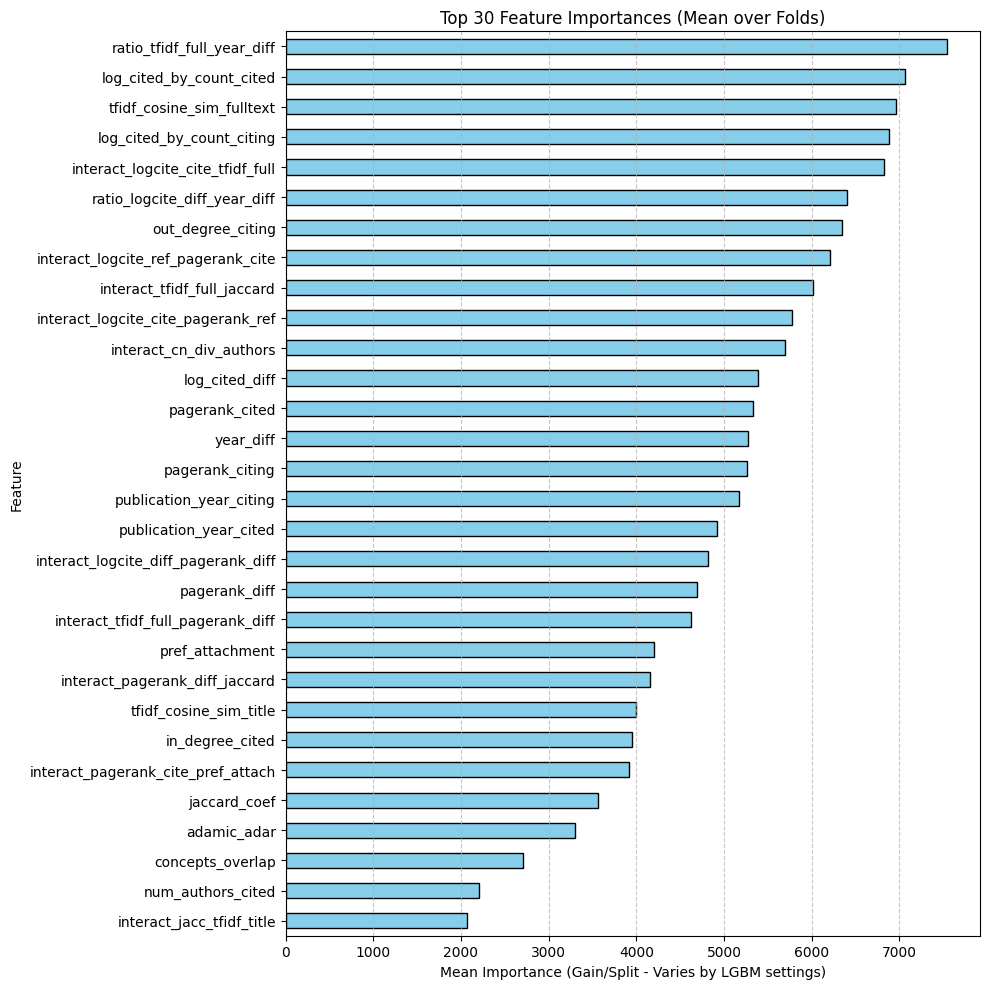


Top 30 Features by Mean Importance:
ratio_tfidf_full_year_diff             7540.8
log_cited_by_count_cited               7065.0
tfidf_cosine_sim_fulltext              6963.4
log_cited_by_count_citing              6877.6
interact_logcite_cite_tfidf_full       6826.8
ratio_logcite_diff_year_diff           6403.8
out_degree_citing                      6343.2
interact_logcite_ref_pagerank_cite     6207.4
interact_tfidf_full_jaccard            6015.0
interact_logcite_cite_pagerank_ref     5770.2
interact_cn_div_authors                5691.2
log_cited_diff                         5387.6
pagerank_cited                         5325.8
year_diff                              5270.0
pagerank_citing                        5267.0
publication_year_citing                5165.8
publication_year_cited                 4923.8
interact_logcite_diff_pagerank_diff    4812.4
pagerank_diff                          4695.8
interact_tfidf_full_pagerank_diff      4621.0
pref_attachment                        4199

In [23]:
# === 18. Display Feature Importance ===
print("\n--- Calculating and Displaying Feature Importance ---")
# Ensure feature_importances DataFrame was populated correctly
if not feature_importances.empty:
    feature_importances['mean'] = feature_importances.mean(axis=1)
    mean_importance_final = feature_importances['mean'].sort_values(ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 10)) # Adjusted size
    mean_importance_final.head(30).plot(kind='barh', title='Top 30 Feature Importances (Mean over Folds)', color='skyblue', edgecolor='black')
    plt.xlabel('Mean Importance (Gain/Split - Varies by LGBM settings)')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\nTop 30 Features by Mean Importance:")
    print(mean_importance_final.head(30))
else:
    print("Feature importances were not calculated (likely due to an issue during training).")

print("\n--- Notebook Execution Complete ---")